# <font color='green'> ***Titanic - Machine Learning from Disaster***</font>

* **Part 1 - Data preprocessing**
        1. Importing libraries
        2. Importing the dataset
        3. Dataset information
        4. Dropping unnecessary columns
           -"Train"
           -"Test"

 5. Taking care of missing values
            -"Train" numerical values
            -"Test" numerical values
            -"Train" Categorical values
            -"Test" Categorical values  
 6. EDA 
 7. Spliting the data for Classify models
 8. RF model
     8.1 Finding best parameters
     8.2 implementing the model
 9. XGBoost model
     9.1 Split data, standardize and fit the data
     9.2 Finding best barameters
     9.3 Implementing
 10. Predictions
 11. Submitting

1. Importing libraries

In [231]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2. Importing Datasets

In [232]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

In [233]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

# 3. Datasets information

## <font color='blue'> **Train dataset**</font>

In [234]:
train_data.info()

## <font color='red'> **Test dataset**</font>

In [235]:
test_data.info()

4. Dropping unnecessary columns

In [236]:
train_data = train_data.drop('Ticket', axis=1)
test_data = test_data.drop('Ticket', axis=1)

# train_data = train_data.drop('PassengerId', axis=1)
# test_data = test_data.drop('PassengerId', axis=1)

## 5. Taking care of missing values

In [237]:
w_null_cols_train_data = pd.DataFrame(columns= ['col', 'num_of_null'])
for col in train_data.columns:
    if train_data[col].isna().sum() > 0:
        row = {'col': col, 'num_of_null':train_data[col].isna().sum()}
        w_null_cols_train_data = w_null_cols_train_data.append(row, ignore_index = True)
        
w_null_cols_test_data = pd.DataFrame(columns= ['col', 'num_of_null'])
for col in test_data.columns:
    if test_data[col].isna().sum() > 0:
        row = {'col': col, 'num_of_null':test_data[col].isna().sum()}
        w_null_cols_test_data = w_null_cols_test_data.append(row, ignore_index = True)        

In [238]:
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,8))


sns.barplot(x='col', y='num_of_null',data= w_null_cols_train_data, order = w_null_cols_train_data.sort_values('num_of_null',ascending=False).col, ax=ax1)
ax1.set_title('Train data missing values')
sns.barplot(x='col', y='num_of_null',data= w_null_cols_test_data, order = w_null_cols_test_data.sort_values('num_of_null',ascending=False).col, ax=ax2)
ax2.set_title('Test data missing values')

Let's take care of the missing values by columns, first - age.

we will fill the missing values with the mean age among all the passengers.

In [239]:
train_data["Age"] = train_data["Age"].fillna(train_data["Age"].mean())
test_data['Age'] = test_data["Age"].fillna(test_data["Age"].mean())

!Now, let's examine the data of the cabin column. if we wnat to search a connection between the person's cabin and the chance of survival - let's look at the scheme of the RMS Titanic : 
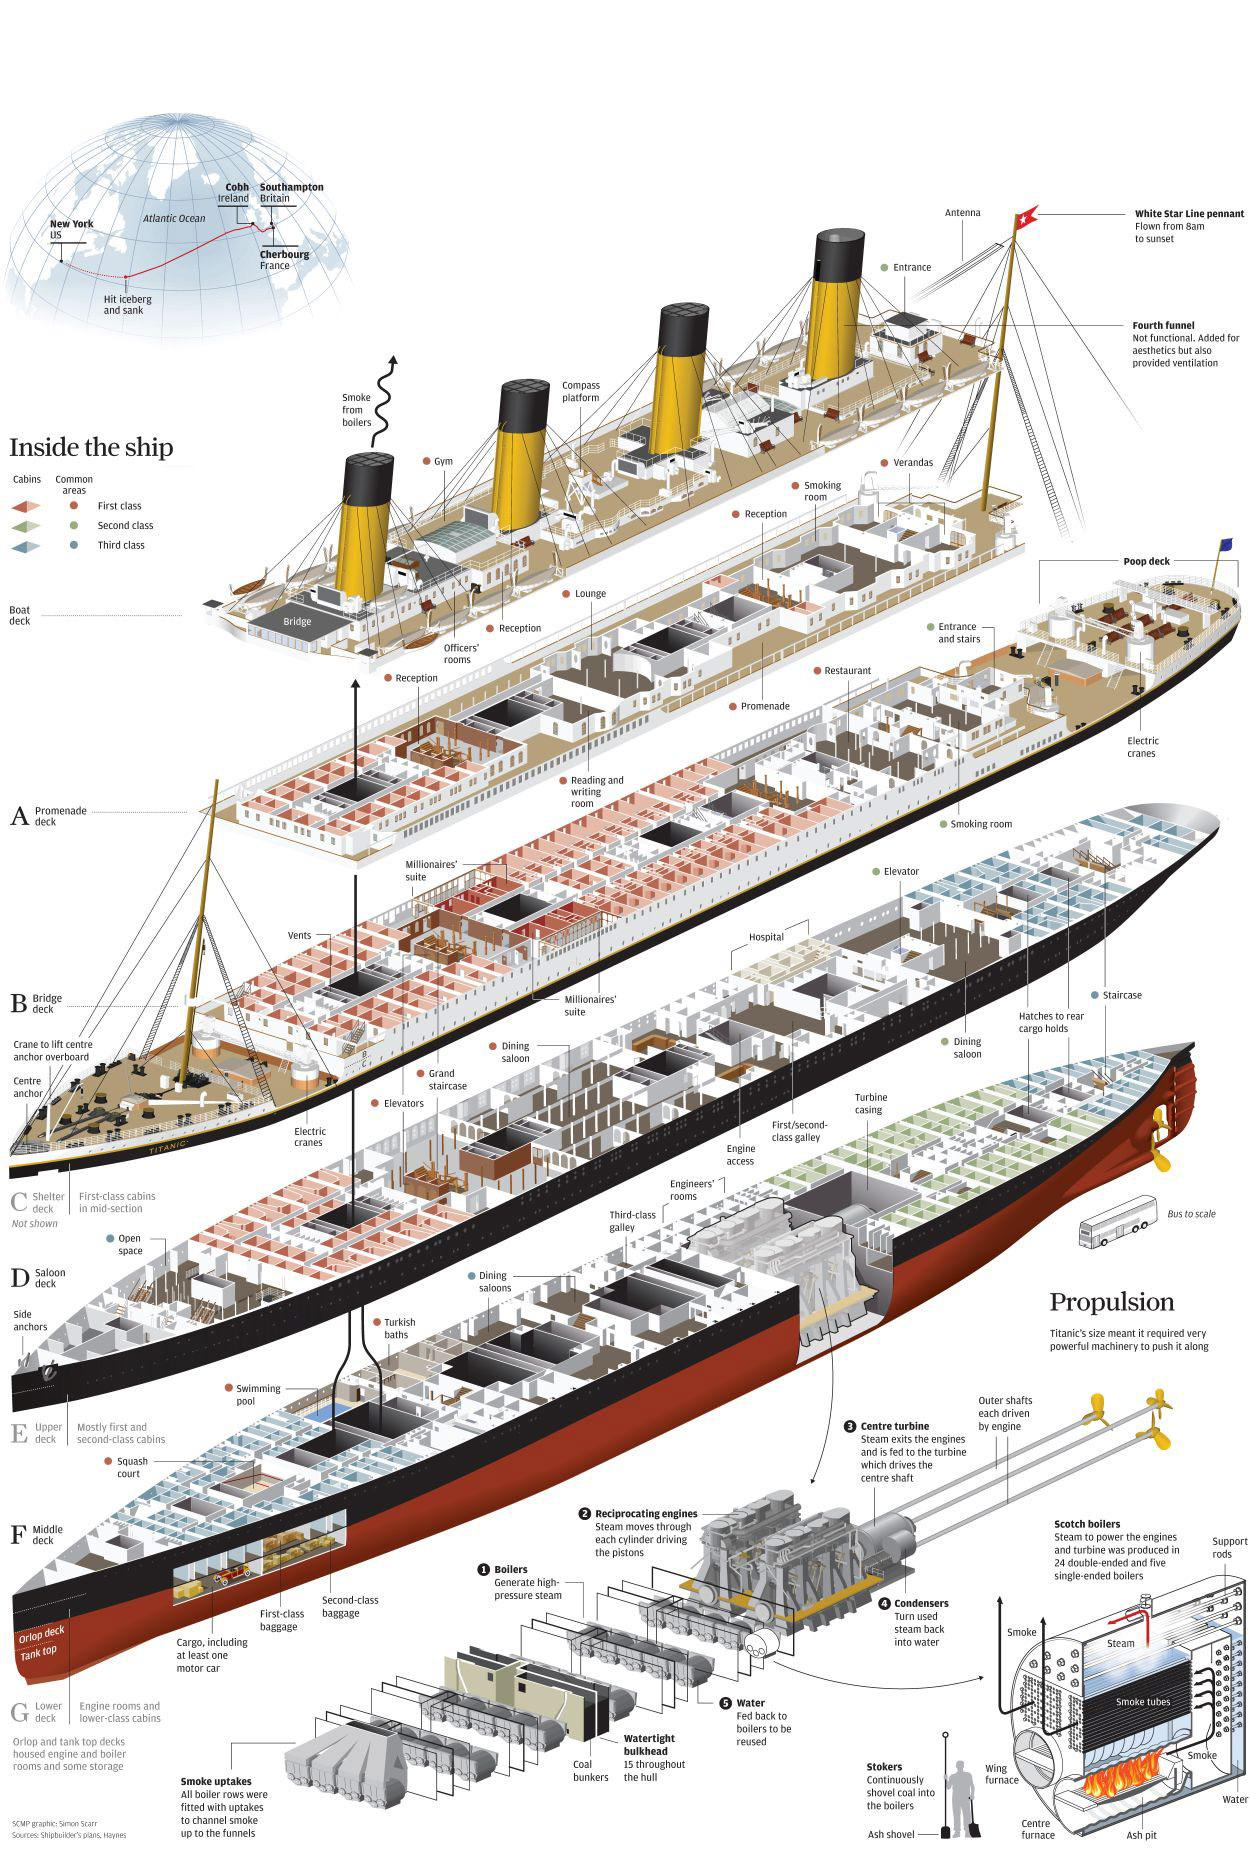

We can see that the access to the life-boats was only throgh the upper deck.

In [240]:
plt.figure(figsize=(76, 26))
sns.countplot(x='Cabin', data=train_data, hue='Survived')

It's hard to notice a certain pattern in the survival rates by cabin but the letter in the cabin name means the deck of the cabin. maybe that data can help us. lets create another coulumn that tells the cabin deck.

In [241]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}
data = [train_data, test_data]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U9")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(9)
    dataset['Deck'] = dataset['Deck'].astype(int)
    
    

In [242]:
train_data['Deck'].value_counts()

In [243]:
test_data['Deck'].value_counts()

### Now we only have the 'Embarked' and 'Fare' columns that have a few missing data entries. We will take care of them by the same method that we did in the 'Age' column.

In [244]:
sns.countplot(x='Embarked',data=train_data, hue='Survived')

### Southampton was the port that the most passengers embarked in, so we will fill the missing data with it'ssign - 'S'

In [245]:
train_data['Embarked'] = train_data['Embarked'].fillna("S")
test_data['Embarked']= test_data['Embarked'].fillna("S")

In [246]:
test_data['Fare'] = test_data['Fare'].fillna(test_data["Fare"].mean())

We're not gonna use the "Name" column, so let's drop it.

In [247]:
train_data = train_data.drop('Name', axis=1)
test_data = test_data.drop('Name', axis=1)

## 6. EDA

In [248]:
sns.countplot(x='Sex', hue='Survived', data=train_data)

### wow! it seems that females have better survival rates. 

### Let's replace "female" values with "1" and "male" with "0"

In [249]:
train_data['Sex'] = train_data['Sex'].map({'male':0,'female':1})
test_data['Sex'] = test_data['Sex'].map({'male':0,'female':1})

In [250]:
sns.lineplot(x='Age', y='Survived', data=train_data)

OK, we can see here a pattern. among the children and the eldery - there was a better survival chances. Let's make a new column that will define the status of the person - child/eldery = 1 or adult = 0.

In [251]:
data = [train_data, test_data]

for dataset in data:
    dataset['status'] = dataset['Age'].apply(lambda x: 1 if (x < 15) else 0)
 

In [252]:
train_data['status'].value_counts()

In [253]:
cor = train_data.corr()
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(cor, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [254]:
cor_target = abs(cor["Survived"])
relevant_features = cor_target[cor_target>0.001]
relevant_features.drop('Survived', inplace=True)
relevant_features

In [255]:
Survived_data = train_data['Survived'].copy()
train_data.drop('Survived',axis=1, inplace=True)
train_data.columns

In [256]:
relevant_features.index

# 7.  Spliting the data for Classify models

In [257]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
y = Survived_data

features = relevant_features.index
X = train_data[features]
X_test = test_data[features]

x_train,x_val,y_train,y_val = train_test_split(X,y,test_size=0.25,random_state=0)

## 8. RF model

## 8.1 Finding the best parameters for the model

In [258]:
# param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50], "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [30, 40, 50, 70, 100]}
# from sklearn.model_selection import GridSearchCV, cross_val_score
# rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
# clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)
# clf.fit(X, y)
# clf.best_params_

In [260]:
score_lst = []

for i in range(5,50,5):
    model = RandomForestClassifier(n_estimators=100, max_depth=i, random_state=1)
    model.fit(X, y)
    predictions = model.predict(X_test)
    model.score(X, y)
    regressor = round(model.score(X, y) * 100, 2)
    score_lst.append(regressor)

In [261]:
values = [val for val in range(5,50,5)]    
plt.figure(figsize=(16, 6))
sns.lineplot(x = values,y = score_lst)


## 8.2 Implementing RF model with the best parameters

In [273]:
random_forest_model = RandomForestClassifier(criterion= 'gini',
 min_samples_leaf= 1,
 min_samples_split= 12,
 n_estimators= 100, max_depth =20, random_state = 1, oob_score = True)
random_forest_model.fit(x_train, y_train)
predictions = random_forest_model.predict(X_test)
random_forest_model.score(x_val, y_val)
model_score = round(random_forest_model.score(x_val, y_val) * 100, 2)
model_score

In [272]:
print("oob score:", round(random_forest_model.oob_score_, 4)*100, "%")

# 9. XGBoost Model

In [264]:
from xgboost import XGBClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

## 9.1 Split, standardize and fit the data

In [265]:
x_train,x_val,y_train,y_val = train_test_split(X,y,test_size=0.25,random_state=0)
min_max_scaler = preprocessing.MinMaxScaler()
x_train_minmax = min_max_scaler.fit_transform(x_train)
x_val_minmax = min_max_scaler.fit_transform(x_val)
X_test_minmax = min_max_scaler.fit_transform(X_test)

## 9.2 Find the best parameters for the model

In [266]:
#Defining the parameters to search within
param_grid = {
'n_estimators': range(6, 12),
'max_depth': range(3, 8),
'learning_rate': [.2, .3, .4],
'colsample_bytree': [.7, .8, .9, 1]
}
#Specifying our classifier
xgb = XGBClassifier(use_label_encoder=False)
#Searching for the best parameters
g_search = GridSearchCV(estimator = xgb, param_grid = param_grid,
cv = 3, n_jobs = 1, verbose = 0, return_train_score=True)
#Fitting the model using best parameters found
g_search.fit(x_train_minmax, y_train)
#Printing the best parameters found
print(g_search.best_params_)

In [267]:
g_search.score(x_val_minmax,y_val)

# 10. predictions

**we can see that the Out Of Bag (oob) score of the RF is lower then the score of the test XGBoost model. So we will use the predictions of the XGB model for submission.**

In [268]:
predictions = g_search.predict(X_test_minmax)
predictions

# 11. Submitting

In [269]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")